<a href="https://colab.research.google.com/github/totiela/Data-Science-IDP/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_Data_Science_IDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи


Задание 1
Опишите задачу с точки зрения NLP. Что это за задача, какие классические методы существуют для ее решения? Как ее можно решать через LLM? Как обычно оценивают качество моделей в этой задаче?


Named Entity Recognition (NER) — это задача в области обработки естественного языка (NLP), направленная на выделение и классификацию именованных сущностей в тексте, таких как имена людей, названия организаций, даты, местоположения, суммы денег и другие типы специфических объектов. NER является важным компонентом многих NLP-приложений, таких как извлечение информации, анализ тональности, вопросно-ответные системы и многие другие, как раз наше направление чат-боты, голосовые ассистенты, смс, телефонные разговоры.

Классические методы решения

Правила и шаблоны (Rule-Based):

- Используются регулярные выражения и словари для распознавания именованных сущностей ,например, ручное написание правил, поиск через ключевые слова.

(плохо масштабируется, не работает на нестандартных данных)

Статистические модели:
- Hidden Markov Models (HMM): Используются для последовательного моделирования текста, основываясь на вероятностях переходов между метками сущностей.
- Conditional Random Fields (CRF): Позволяют моделировать зависимость между соседними токенами для более точного предсказания.

(требуют многоразметных данных и плохо работают с семантическими особенностями текста)

Классические нейронные сети:
- Recurrent Neural Networks (RNN): Используют последовательные зависимости между токенами.
- BiLSTM-CRF: BiLSTM используется для извлечения контекстных признаков, а CRF — для оптимального прогнозирования меток.

(ограниченная способность понимать сложные зависимости)

Решение через LLM

Large Language Models (LLMs) могут решать задачу NER более универсально, используя предобученные языковые представления.
Подходы включают:

- Fine-tuning: Модель дообучается на размеченном наборе данных для конкретной задачи
- Prompt Engineering: Формирование запросов к LLM для выполнения задачи NER без дообучения


Качество NER-моделей оценивается через метрики, которые учитывают как точность, так и полноту предсказаний:
- Precision: Доля правильных предсказаний среди всех предсказанных сущностей.
- Recall: Доля правильных предсказаний среди всех сущностей в эталоне.
- F1-score: Гармоническое среднее Precision и Recall.
- Entity-Level Accuracy: Оценивает точность классификации всей сущности целиком (не только на уровне токенов).

и др.

# Чтение датафрейма

In [120]:
# Клонируем репозиторий
!git clone https://github.com/totiela/Data-Science-IDP.git

# Переходим в папку с репозиторием
%cd Data-Science-IDP

# Проверяем наличие файла
!ls

Cloning into 'Data-Science-IDP'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 113.44 KiB | 22.69 MiB/s, done.
/content/Data-Science-IDP
README.md  sample_pl_cs_ru_bg.zip


In [121]:
# Распаковка файла
!unzip sample_pl_cs_ru_bg.zip -d unzipped_folder

Archive:  sample_pl_cs_ru_bg.zip
   creating: unzipped_folder/sample_pl_cs_ru_bg/
   creating: unzipped_folder/sample_pl_cs_ru_bg/annotated/
   creating: unzipped_folder/sample_pl_cs_ru_bg/annotated/bg/
  inflating: unzipped_folder/sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_1.out  
  inflating: unzipped_folder/sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_11.out  
  inflating: unzipped_folder/sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_13.out  
  inflating: unzipped_folder/sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_14.out  
  inflating: unzipped_folder/sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_15.out  
  inflating: unzipped_folder/sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_16.out  
  inflating: unzipped_folder/sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_17.out  
  inflating: unzipped_folder/sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_19.out  
  inflating: unzipped_folder/sample_pl_cs_ru_bg/annotated/bg/brexit_bg.txt_file_2.out 

Задание 2
Реализуйте чтение датасета в pandas DataFrame с обязательными колонками "document_id", "document_text", "entity", "gold_answer". Выведите шапку датафрейма.


In [122]:
import os
import pandas as pd

def parse_document(file_path):
    """Парсинг текстового файла с извлечением языка, даты и текста документа."""
    documents = []
    current_doc = {}
    state = 'idle'  # Для отслеживания этапов обработки документа

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue  # Пропуск пустых строк

            # Если это идентификатор документа
            if line.startswith('ru-'):
                if current_doc:  # Если текущий документ заполнен, добавляем его в список
                    documents.append(current_doc)
                current_doc = {'document_id': line}  # Инициализация нового документа
                state = 'expect_language'  # Следующая строка должна быть языком

            # Если это язык
            elif state == 'expect_language':
                current_doc['language'] = line
                state = 'expect_date'  # Следующая строка должна быть датой

            # Если это дата
            elif state == 'expect_date' and line.count('-') == 2 and len(line) == 10:
                current_doc['date'] = line
                state = 'expect_url_or_text'  # Следующая строка может быть URL или текстом

            # Если это URL
            elif line.startswith('http') or line.startswith('https'):
                current_doc['url'] = line

            # Если это текст
            else:
                current_doc['document_text'] = current_doc.get('document_text', '') + ' ' + line

        # Добавить последний документ
        if current_doc:
            documents.append(current_doc)

    return pd.DataFrame(documents)

def parse_all_files_in_folder(folder_path):
    """Парсинг всех файлов в указанной папке в порядке их расположения сверху вниз."""
    all_documents = []
    for file_name in sorted(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):  # Проверяем, что это файл
            try:
                df = parse_document(file_path)
                all_documents.append(df)
                print(f"Обработан файл: {file_name}")
            except Exception as e:
                print(f"Ошибка при обработке файла {file_name}: {e}")

    # Объединяем все DataFrame в один
    if all_documents:
        return pd.concat(all_documents, ignore_index=True)
    else:
        return pd.DataFrame()


In [123]:
# Путь к папке с файлами
folder_path = '/content/Data-Science-IDP/unzipped_folder/sample_pl_cs_ru_bg/raw/ru'

# Парсим все файлы из папки
df = parse_all_files_in_folder(folder_path)

Обработан файл: brexit_ru.txt_file_10.txt
Обработан файл: brexit_ru.txt_file_1000.txt
Обработан файл: brexit_ru.txt_file_1001.txt
Обработан файл: brexit_ru.txt_file_1002.txt
Обработан файл: brexit_ru.txt_file_1003.txt
Обработан файл: brexit_ru.txt_file_1004.txt
Обработан файл: brexit_ru.txt_file_1006.txt
Обработан файл: brexit_ru.txt_file_1011.txt
Обработан файл: brexit_ru.txt_file_1017.txt


In [125]:
df.head()

,document_id,language,date,url,document_text
0,ru-10,ru,2018-09-20,https://rg.ru/2018/09/20/tereza-mej-rasschityv...,Тереза Мэй рассчитывает усидеть в седле до за...
1,ru-1000,ru,2018-07-09,http://news.meta.ua/ua/cluster:60407124-Boris-...,Подробности.ua: Третий за сутки: Борис Джонсо...
2,ru-1001,ru,2018-07-09,https://rg.ru/2018/07/09/boris-dzhonson-podal-...,Глава МИД Британии Борис Джонсон подал в отст...
3,ru-1002,ru,2018-07-09,https://echo.msk.ru/news/2237252-echo.html,09.07.2018 18:09 : Премьер-министр Великобрит...
4,ru-1003,ru,2018-07-09,https://echo.msk.ru/news/2237216-echo.html,09.07.2018 17:02 : Министр иностранных дел Ве...


In [126]:
# Функция для обработки одного файла разметки
def process_annotation_file(doc_id, annotation_path):
    try:
        with open(annotation_path, "r", encoding="utf-8") as f:
            lines = f.readlines()

        # Пропустить первую строку (ID документа)
        annotations = []
        for line in lines[1:]:
            parts = line.strip().split("\t")
            if len(parts) >= 3:  # Проверяем, что строка содержит хотя бы 3 столбца
                _, gold_answer, entity = parts[:3]
                annotations.append({"document_id": doc_id, "entity": entity, "gold_answer": gold_answer})
        return annotations
    except FileNotFoundError:
        print(f"Annotation file for document {doc_id} not found.")
        return []

In [127]:
# Обработка каждого документа

# Путь к папке с разметкой
annotation_folder = "/content/Data-Science-IDP/unzipped_folder/sample_pl_cs_ru_bg/annotated/ru"


all_annotations = []
for idx, row in df.iterrows():
    doc_id = row["document_id"]
    annotation_file = os.path.join(annotation_folder, f"brexit_ru.txt_file_{doc_id.split('-')[-1]}.out")
    annotations = process_annotation_file(doc_id, annotation_file)

    if annotations:
        all_annotations.extend(annotations)

# Создаем DataFrame из разметки
annotations_df = pd.DataFrame(all_annotations)

In [128]:
annotations_df.head()

,document_id,entity,gold_answer
0,ru-10,EVT,Brexit
1,ru-10,LOC,Альбион
2,ru-10,LOC,Альбион
3,ru-10,PER,Борис Джонсон
4,ru-10,LOC,Британия


In [130]:
# Объединяем исходный DataFrame с аннотациями
final_df = pd.merge(df, annotations_df, on="document_id", how="left")

In [131]:
final_df

,document_id,language,date,url,document_text,entity,gold_answer
0,ru-10,ru,2018-09-20,https://rg.ru/2018/09/20/tereza-mej-rasschityv...,Тереза Мэй рассчитывает усидеть в седле до за...,EVT,Brexit
1,ru-10,ru,2018-09-20,https://rg.ru/2018/09/20/tereza-mej-rasschityv...,Тереза Мэй рассчитывает усидеть в седле до за...,LOC,Альбион
2,ru-10,ru,2018-09-20,https://rg.ru/2018/09/20/tereza-mej-rasschityv...,Тереза Мэй рассчитывает усидеть в седле до за...,LOC,Альбион
3,ru-10,ru,2018-09-20,https://rg.ru/2018/09/20/tereza-mej-rasschityv...,Тереза Мэй рассчитывает усидеть в седле до за...,PER,Борис Джонсон
4,ru-10,ru,2018-09-20,https://rg.ru/2018/09/20/tereza-mej-rasschityv...,Тереза Мэй рассчитывает усидеть в седле до за...,LOC,Британия
...,...,...,...,...,...,...,...
148,ru-1017,ru,2018-07-09,http://www.unn.com.ua/ru/news/1740316-boris-dz...,Борис Джонсон подал в отставку с поста минист...,LOC,КИЕВ
149,ru-1017,ru,2018-07-09,http://www.unn.com.ua/ru/news/1740316-boris-dz...,Борис Джонсон подал в отставку с поста минист...,ORG,МИД Соединенного Королевства
150,ru-1017,ru,2018-07-09,http://www.unn.com.ua/ru/news/1740316-boris-dz...,Борис Джонсон подал в отставку с поста минист...,PER,Стив Бейкер
151,ru-1017,ru,2018-07-09,http://www.unn.com.ua/ru/news/1740316-boris-dz...,Борис Джонсон подал в отставку с поста минист...,PER,Тереза Мэй


Задание 3
Напишите функцию, которая принимает на вход строку датафрейма и выдает текст входного сообщения для LLM.


In [132]:
def create_llm_input_message(row):
    """
    Создает текст входного сообщения для LLM из строки датафрейма.

    Args:
        row (pd.Series): Строка датафрейма с колонками 'document_id', 'document_text'.

    Returns:
        str: Текст входного сообщения для LLM.
    """
    document_id = row['document_id']
    document_text = row['document_text']
    json_example = '''
{
  "События": ['Название события', 'Название события', ...],
  ],
  "Локации": [
    ["Название локации", "Название локации", ...],
  ],
  "Личности": [
    ["Название личности", "Название личности", ...],
  ],
  "Организации": [
    ["Название организации", "Название организации", ...],
  ],
  "Продукты": [
    ["Название продукта", "Название продукта", ...],
  ]
}
'''

    input_message = f'''
Ты — нейросетевая модель для задачи NER (Named Entity Recognition).
Твоя цель — выделить именованные сущности из текста, классифицировать их по категориям и вернуть результат в формате JSON.

**Описание категорий:**
  - 'События': Названные события или действия, например, конференции, катастрофы, праздники.
  - 'Локации': Географические объекты (города, страны, регионы) и инфраструктура (мосты, аэропорты).
  - 'Личности': Имена людей, включая вымышленных (например, Джон Смит, Джеймс Бонд).
  - 'Организации': Названия формальных групп (например, Европейский Союз, NASA).
  - 'Продукты': Товары, технологии, фильмы, книги (например, смартфон Galaxy, Twitter).

**Требования:**
1. Извлеки ВСЕ сущности, упомянутые в тексте, для каждой из категорий.
2. Возвращай только заполненные данные в формате JSON. Если для какой-либо категории сущностей нет, оставь её пустым массивом.
3. Формат ответа строго определён:
{json_example}

**Текст документа:**
Документ ID: {document_id}
{document_text}

Ответь только в указанном формате JSON. Не добавляй описание, инструкции или код — только заполненный JSON.
'''
    return input_message

In [133]:
# Пример промпта для модели
print(create_llm_input_message(df.iloc[0]))


Ты — нейросетевая модель для задачи NER (Named Entity Recognition). 
Твоя цель — выделить именованные сущности из текста, классифицировать их по категориям и вернуть результат в формате JSON.

**Описание категорий:**
  - 'События': Названные события или действия, например, конференции, катастрофы, праздники.
  - 'Локации': Географические объекты (города, страны, регионы) и инфраструктура (мосты, аэропорты).
  - 'Личности': Имена людей, включая вымышленных (например, Джон Смит, Джеймс Бонд).
  - 'Организации': Названия формальных групп (например, Европейский Союз, NASA).
  - 'Продукты': Товары, технологии, фильмы, книги (например, смартфон Galaxy, Twitter).

**Требования:**
1. Извлеки ВСЕ сущности, упомянутые в тексте, для каждой из категорий.
2. Возвращай только заполненные данные в формате JSON. Если для какой-либо категории сущностей нет, оставь её пустым массивом.
3. Формат ответа строго определён: 

{
  "События": ['Название события', 'Название события', ...],
  ],
  "Локации": [


# GigaChat

Задание 4
Получите ответы GigaChat для всех документов. Документов всего 9, поэтому сделать это можно вручную, пользуясь веб-интерфейсом GigaChat или ботом в ВК или Телеграме. Не очищайте историю сообщений, чтобы потом продемонстрировать подлинность ответов на онлайн-собеседовании.


Я решил сделать через gigachat API и фреймворк gigachain

In [18]:
!pip install -q langchain-gigachat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.6 MB/s eta 0:00:00


In [19]:
from google.colab import userdata

auth = userdata.get('SBER_AUTH')

In [20]:
from langchain_gigachat.chat_models import GigaChat

model = GigaChat(
    credentials=auth,
    scope="GIGACHAT_API_PERS",
    model="GigaChat",
    streaming=False,
    verify_ssl_certs=False,
)

In [30]:
from tqdm import tqdm
import json
from langchain_core.output_parsers import StrOutputParser

# Модель и цепочка
chain = model | StrOutputParser()

# Словарь для сопоставления категорий
category_mapping = {
    "События": "EVT",
    "Локации": "LOC",
    "Личности": "PER",
    "Организации": "ORG",
    "Продукты": "PRO"
}

# Итоговый DataFrame
all_predictions = []

# Обработка всех строк с прогрессом
for _, row in tqdm(df.iterrows(), total=len(df), desc="Обработка строк"):
    document_id = row.get("document_id", "unknown")  # Получение ID текущей строки
    try:
        # Создание сообщения
        llm_input_message = create_llm_input_message(row)

        # Получение ответа модели
        output = chain.invoke(llm_input_message)

        # Преобразование строки JSON в словарь
        model_output = json.loads(output)

        # Преобразование категорий
        for category, values in model_output.items():
            mapped_category = category_mapping.get(category, category)
            for value in values:
                all_predictions.append({
                    'document_id': document_id,
                    'entity': mapped_category,
                    'prediction': value
                })

    except Exception as e:
        print(f"Ошибка при обработке строки: {document_id}\n{e}")

# Создание итогового DataFrame
result_df = pd.DataFrame(all_predictions, columns=["document_id", "entity", "prediction"])

# Вывод результата
print(result_df)

Обработка строк: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]

Ошибка при обработке строки: ru-1017
Expecting value: line 1 column 1 (char 0)
   document_id entity               prediction
0        ru-10    EVT                   Brexit
1        ru-10    EVT  конференция партии тори
2        ru-10    LOC           Великобритания
3        ru-10    LOC        Северная Ирландия
4        ru-10    LOC         Европейский Союз
..         ...    ...                      ...
57     ru-1011    PER            Борис Джонсон
58     ru-1011    PER               Тереза Мэй
59     ru-1011    PER              Дэвид Дэвис
60     ru-1011    ORG         Европейский Союз
61     ru-1011    ORG           Великобритания

[62 rows x 3 columns]


Один текст модель GigaChat не обработала из-за блэклиста

In [32]:
df[df.document_id=='ru-1017'].document_text.values

array([' Борис Джонсон подал в отставку с поста министра иностранных дел Великобритании КИЕВ. 9 июля. УНН. Борис Джонсон подал в отставку с поста министра иностранных дел Великобритании. Об этом сообщает The Guardian, передает УНН. "Сегодня днем премьер-министр принял отставку Бориса Джонсона с поста качестве министра иностранных дел. Его замена будет объявлена в ближайшее время. Премьер-министр благодарит Бориса за его работу", - сообщил пресс-секретарь британского парламента. Таким образом, Джонсон стал третьим министром, который покинул свой пост в течении суток. Ранее о своем уходе объявили министр по вопросам выхода Великобритании из ЕС Дэвид Дэвис и заместитель министра по Brexit Стив Бейкер. Напомним, ранее премьер-министр Великобритании Тереза Мэй пообещала отправить в отставку главу МИД Соединенного Королевства Бориса Джонсона, если он попытается ослабить согласованную ее кабинетом коллективную позицию относительно будущих переговоров с ЕС.'],
      dtype=object)

In [191]:
# Сохраняем предсказания в csv
result_df.to_csv('gigachat_light_preds.csv', index=False)

# Метрики

Задание 5
Реализуйте самостоятельно алгоритм для подсчета метрик score_fn(gold: str, pred: str) → float. Можно пользоваться только библиотеками numpy, scipy, pandas. Напишите юнит-тесты. Возможно ли ускорить вычисление функции через векторную реализацию? Поясните решение и обоснуйте, почему выбрали именно такую метрику.


Я реализую подсчет метрики по всему датафрейму, а в следующем пункте из текущем пункте реализую применение этой метрики по строкам.


Я выбрал метрики precision, recall и их гармоническое среднее - f1, чтобы учитывать дисбаланс классов и отслеживать такие показатели как:
- какая доля предсказанных сущностей является корректной
- какая доля сущностей из эталонной разметки была найдена моделью
- гармоническое среднее между Precision и Recall, которое используется для баланса между ними.

In [95]:
true_df = final_df[final_df.document_id != 'ru-1017'][['document_id', 'entity', 'gold_answer']]
true_df = true_df.drop_duplicates()

Проверим 3 разные версии: с numpy, pandas и set

In [86]:
import pandas as pd
import numpy as np

# Реализация 1: Использует numpy
def score_fn_1(gold_df: pd.DataFrame, pred_df: pd.DataFrame) -> dict:
    cols = ['document_id', 'entity', 'gold_answer']
    gold = np.unique(gold_df[cols].to_records(index=False))
    pred = np.unique(pred_df.rename(columns={'prediction': 'gold_answer'})[cols].to_records(index=False))

    tp = len(np.intersect1d(gold, pred))
    fp = len(np.setdiff1d(pred, gold))
    fn = len(np.setdiff1d(gold, pred))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {'precision': precision, 'recall': recall, 'f1': f1}

# Реализация 2: Использует pandas.merge
def score_fn_2(gold_df: pd.DataFrame, pred_df: pd.DataFrame) -> dict:
    pred_df = pred_df.rename(columns={'prediction': 'gold_answer'})

    merged = pd.merge(
        gold_df,
        pred_df,
        on=['document_id', 'entity', 'gold_answer'],
        how='outer',
        indicator=True
    )

    tp = (merged['_merge'] == 'both').sum()
    fp = (merged['_merge'] == 'right_only').sum()
    fn = (merged['_merge'] == 'left_only').sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {'precision': precision, 'recall': recall, 'f1': f1}

# Реализация 3: Использует множества (set)
def score_fn_3(gold_df: pd.DataFrame, pred_df: pd.DataFrame) -> dict:
    cols = ['document_id', 'entity', 'gold_answer']
    gold_set = set(gold_df[cols].itertuples(index=False, name=None))
    pred_set = set(pred_df.rename(columns={'prediction': 'gold_answer'})[cols].itertuples(index=False, name=None))

    tp = len(gold_set & pred_set)
    fp = len(pred_set - gold_set)
    fn = len(gold_set - pred_set)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {'precision': precision, 'recall': recall, 'f1': f1}

Протестируем производительность всех функций

In [87]:
import time

# Генерация данных
def generate_data(num_rows: int, overlap_ratio: float = 0.5) -> tuple:
    np.random.seed(42)
    document_ids = np.arange(num_rows)
    entities = np.random.choice(['PER', 'LOC', 'ORG', 'EVT', 'PRO'], size=num_rows)
    gold_answers = np.random.choice(['Alice', 'London', 'NASA', 'Event1', 'Product1'], size=num_rows)

    gold_df = pd.DataFrame({
        'document_id': document_ids,
        'entity': entities,
        'gold_answer': gold_answers
    })

    overlap_size = int(num_rows * overlap_ratio)
    pred_df = gold_df.sample(n=overlap_size, random_state=42)
    additional_preds = pd.DataFrame({
        'document_id': np.arange(num_rows, num_rows + num_rows - overlap_size),
        'entity': np.random.choice(['PER', 'LOC', 'ORG', 'EVT', 'PRO'], size=num_rows - overlap_size),
        'prediction': np.random.choice(['Alice', 'London', 'NASA', 'Event1', 'Product1'], size=num_rows - overlap_size)
    })

    pred_df = pd.concat([pred_df.rename(columns={'gold_answer': 'prediction'}), additional_preds], ignore_index=True)
    return gold_df, pred_df

# Тестируем производительность
gold_df, pred_df = generate_data(10000)

# Измерение времени
start = time.time()
score_fn_1(gold_df, pred_df)
time_1 = time.time() - start

start = time.time()
score_fn_2(gold_df, pred_df)
time_2 = time.time() - start

start = time.time()
score_fn_3(gold_df, pred_df)
time_3 = time.time() - start

# Вывод результатов
print(f"score_fn_1 (numpy): {time_1:.4f} seconds")
print(f"score_fn_2 (pandas): {time_2:.4f} seconds")
print(f"score_fn_3 (set): {time_3:.4f} seconds")

# Определение самой быстрой реализации
fastest_fn = min((time_1, 'score_fn_1'), (time_2, 'score_fn_2'), (time_3, 'score_fn_3'))
print(f"Самая быстрая реализация: {fastest_fn[1]} ({fastest_fn[0]:.4f} seconds)")

score_fn_1 (numpy): 14.4646 seconds
score_fn_2 (pandas): 0.0247 seconds
score_fn_3 (set): 0.0203 seconds
Самая быстрая реализация: score_fn_3 (0.0203 seconds)


Numpy реализация явно проигрывает другим двум из-за того, что gреобразование DataFrame в numpy с помощью .to_records() для больших данных становится узким местом + np.intersect1d и np.setdiff1d выполняют сравнения на уровне массивов, что требует сортировки массивов под капотом. Это значительно увеличивает время выполнения при большом количестве строк.

Не понятна ситуация с pandas и set - что производительнее?
Сравним их отдельно на более больших данных.

In [93]:
# Тестируем производительность на более больших данных
gold_df, pred_df = generate_data(1000000)

start = time.time()
score_fn_2(gold_df, pred_df)
time_2 = time.time() - start

start = time.time()
score_fn_3(gold_df, pred_df)
time_3 = time.time() - start

# Вывод результатов
print(f"score_fn_2 (pandas): {time_2:.4f} seconds")
print(f"score_fn_3 (set): {time_3:.4f} seconds")

# Определение самой быстрой реализации
fastest_fn = min((time_2, 'score_fn_2'), (time_3, 'score_fn_3'))
print(f"Самая быстрая реализация: {fastest_fn[1]} ({fastest_fn[0]:.4f} seconds)")

score_fn_2 (pandas): 2.0730 seconds
score_fn_3 (set): 3.4421 seconds
Самая быстрая реализация: score_fn_2 (2.0730 seconds)


Тут Pandas реализация уже выигрывает - выбираем ее как финальную и делаем юнит тесты.

In [105]:
def score_fn(gold_df: pd.DataFrame, pred_df: pd.DataFrame) -> dict:
    pred_df = pred_df.rename(columns={'prediction': 'gold_answer'})

    merged = pd.merge(
        gold_df,
        pred_df,
        on=['document_id', 'entity', 'gold_answer'],
        how='outer',
        indicator=True
    )

    tp = (merged['_merge'] == 'both').sum()
    fp = (merged['_merge'] == 'right_only').sum()
    fn = (merged['_merge'] == 'left_only').sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {'precision': precision, 'recall': recall, 'f1': f1}

In [106]:
import unittest

# Тесты
class TestScoreFnFast(unittest.TestCase):

    def test_exact_match(self):
        """Тест для идеально совпадающих данных"""
        gold_df = pd.DataFrame({
            'document_id': [1, 2, 3],
            'entity': ['PER', 'LOC', 'ORG'],
            'gold_answer': ['Alice', 'London', 'NASA']
        })
        pred_df = pd.DataFrame({
            'document_id': [1, 2, 3],
            'entity': ['PER', 'LOC', 'ORG'],
            'prediction': ['Alice', 'London', 'NASA']
        })
        result = score_fn(gold_df, pred_df)
        self.assertEqual(result, {'precision': 1.0, 'recall': 1.0, 'f1': 1.0})

    def test_partial_match(self):
        """Тест для частично совпадающих данных"""
        gold_df = pd.DataFrame({
            'document_id': [1, 2, 3],
            'entity': ['PER', 'LOC', 'ORG'],
            'gold_answer': ['Alice', 'London', 'NASA']
        })
        pred_df = pd.DataFrame({
            'document_id': [1, 2],
            'entity': ['PER', 'LOC'],
            'prediction': ['Alice', 'Paris']
        })
        result = score_fn(gold_df, pred_df)
        self.assertEqual(result, {'precision': 0.5, 'recall': 0.3333333333333333, 'f1': 0.4})

    def test_extra_predictions(self):
        """Тест для лишних предсказаний"""
        gold_df = pd.DataFrame({
            'document_id': [1, 2],
            'entity': ['PER', 'LOC'],
            'gold_answer': ['Alice', 'London']
        })
        pred_df = pd.DataFrame({
            'document_id': [1, 2, 3],
            'entity': ['PER', 'LOC', 'ORG'],
            'prediction': ['Alice', 'London', 'NASA']
        })
        result = score_fn(gold_df, pred_df)
        self.assertEqual(result, {'precision': 0.6666666666666666, 'recall': 1.0, 'f1': 0.8})

    def test_missing_predictions(self):
        """Тест для отсутствующих предсказаний"""
        gold_df = pd.DataFrame({
            'document_id': [1, 2, 3],
            'entity': ['PER', 'LOC', 'ORG'],
            'gold_answer': ['Alice', 'London', 'NASA']
        })
        pred_df = pd.DataFrame({
            'document_id': [1],
            'entity': ['PER'],
            'prediction': ['Alice']
        })
        result = score_fn(gold_df, pred_df)
        self.assertEqual(result, {'precision': 1.0, 'recall': 0.3333333333333333, 'f1': 0.5})

    def test_empty_gold(self):
        """Тест для пустого gold_df"""
        gold_df = pd.DataFrame(columns=['document_id', 'entity', 'gold_answer'])
        pred_df = pd.DataFrame({
            'document_id': [1],
            'entity': ['PER'],
            'prediction': ['Alice']
        })
        result = score_fn(gold_df, pred_df)
        self.assertEqual(result, {'precision': 0.0, 'recall': 0.0, 'f1': 0.0})

    def test_empty_predictions(self):
        """Тест для пустого pred_df"""
        gold_df = pd.DataFrame({
            'document_id': [1],
            'entity': ['PER'],
            'gold_answer': ['Alice']
        })
        pred_df = pd.DataFrame(columns=['document_id', 'entity', 'prediction'])
        result = score_fn(gold_df, pred_df)
        self.assertEqual(result, {'precision': 0.0, 'recall': 0.0, 'f1': 0.0})

    def test_empty_both(self):
        """Тест для обоих пустых DataFrame"""
        gold_df = pd.DataFrame(columns=['document_id', 'entity', 'gold_answer'])
        pred_df = pd.DataFrame(columns=['document_id', 'entity', 'prediction'])
        result = score_fn(gold_df, pred_df)
        self.assertEqual(result, {'precision': 0.0, 'recall': 0.0, 'f1': 0.0})

    def test_duplicate_rows(self):
        """Тест для дублирующихся строк"""
        gold_df = pd.DataFrame({
            'document_id': [1, 1, 2],
            'entity': ['PER', 'PER', 'LOC'],
            'gold_answer': ['Alice', 'Alice', 'London']
        })
        pred_df = pd.DataFrame({
            'document_id': [1, 2, 2],
            'entity': ['PER', 'LOC', 'LOC'],
            'prediction': ['Alice', 'London', 'London']
        })
        result = score_fn(gold_df, pred_df)
        self.assertEqual(result, {'precision': 1.0, 'recall': 1.0, 'f1': 1.0})

if __name__ == "__main__":
    unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestScoreFnFast))

........
----------------------------------------------------------------------
Ran 8 tests in 0.102s

OK


Вычислите метрики для каждой строки в датафрейме. Сагрегируйте результаты а) по каждой сущности, б) по каждому документу. Изобразите результаты на графиках. Какие выводы можно сделать?

Для оценки я не буду использовать документ "ru-1017", который попал в блэклист, а также уберу дубликаты.

In [136]:
# Убираем дубликаты и документ из блэклиста
true_df = final_df[final_df.document_id != 'ru-1017'][['document_id', 'entity', 'gold_answer']]
true_df = true_df.drop_duplicates()

In [138]:
# Общий score по нашей метрике
score_fn(true_df, result_df)

{'precision': 0.4032258064516129, 'recall': 0.25510204081632654, 'f1': 0.3125}

In [159]:
def score_row(row, gold_df, pred_df):
    """
    Вычисляет метрики для отдельной строки.
    """
    gold = gold_df[
        (gold_df['document_id'] == row['document_id']) &
        (gold_df['entity'] == row['entity'])
    ]
    pred = pred_df[
        (pred_df['document_id'] == row['document_id']) &
        (pred_df['entity'] == row['entity'])
    ]
    return score_fn(gold, pred)


gold_df = true_df.copy()
pred_df = result_df.copy()
# Создаем столбцы для метрик
gold_df['metrics'] = gold_df.apply(lambda row: score_row(row, gold_df, pred_df), axis=1)
# Распаковываем метрики
gold_df[['precision', 'recall', 'f1']] = pd.DataFrame(gold_df['metrics'].tolist(), index=gold_df.index)
gold_df.drop(columns='metrics', inplace=True)

In [140]:
gold_df.head()

,document_id,entity,gold_answer,precision,recall,f1
0,ru-10,EVT,Brexit,0.5,0.333333,0.400000
1,ru-10,LOC,Альбион,0.6,0.375000,0.461538
3,ru-10,PER,Борис Джонсон,1.0,0.714286,0.833333
4,ru-10,LOC,Британия,0.6,0.375000,0.461538
6,ru-10,LOC,Брюссель,0.6,0.375000,0.461538


In [141]:
# Группировка по сущностям
entity_metrics = gold_df.groupby('entity')[['precision', 'recall', 'f1']].mean()
entity_metrics

,precision,recall,f1
entity,,,
EVT,0.150000,0.100000,0.120000
LOC,0.266667,0.166667,0.205128
ORG,0.101852,0.074074,0.075973
PER,0.815385,0.487179,0.601815
PRO,0.000000,0.000000,0.000000


In [142]:
# Группировка по документам
doc_metrics = gold_df.groupby('document_id')[['precision', 'recall', 'f1']].mean()
doc_metrics

,precision,recall,f1
document_id,,,
ru-10,0.575926,0.370370,0.448528
ru-1000,0.369231,0.307692,0.335664
ru-1001,0.384615,0.153846,0.219780
ru-1002,0.000000,0.000000,0.000000
ru-1003,0.500000,0.300000,0.375000
ru-1004,0.000000,0.000000,0.000000
ru-1006,0.409091,0.272727,0.303030
ru-1011,0.500000,0.250000,0.333333


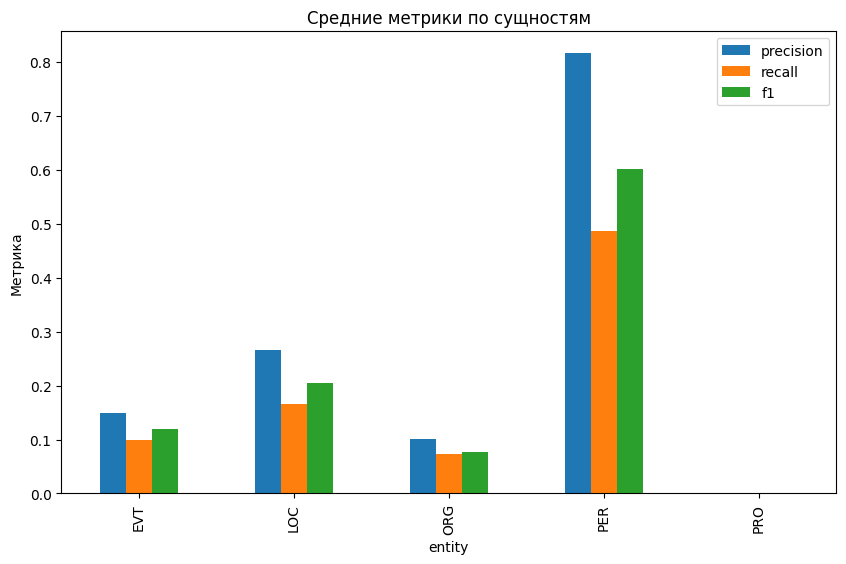

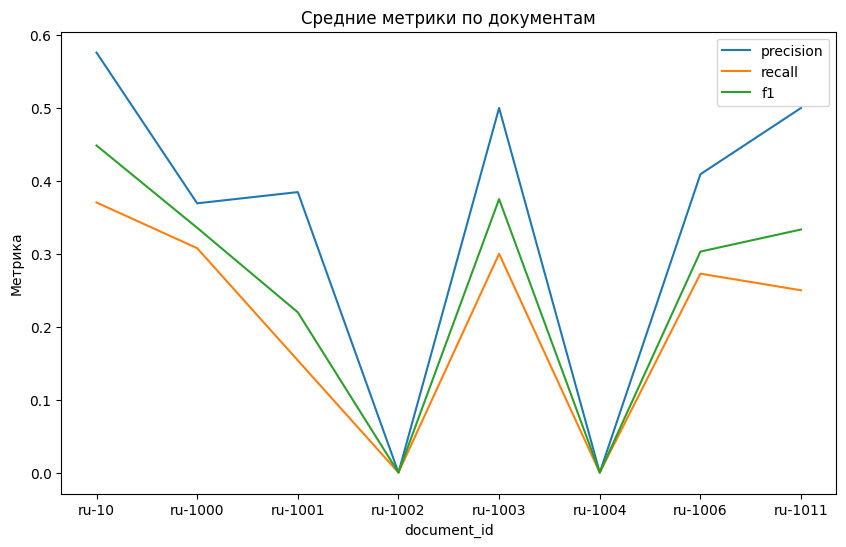

In [143]:
import matplotlib.pyplot as plt

# График для сущностей
entity_metrics.plot(kind='bar', figsize=(10, 6), title='Средние метрики по сущностям')
plt.ylabel('Метрика')
plt.show()

# График для документов
doc_metrics.plot(kind='line', figsize=(10, 6), title='Средние метрики по документам')
plt.ylabel('Метрика')
plt.show()

Видим, что модель неплохо справляется с категорией "Личности", однако с остальными у нее наблюдаются проблемы, а из категории "Продукты" нет вообще правильных предсказаний.

Precision везде больше, чем recall, что говорит о том, что модель пытается "бить" точечно и старается избегать ложных срабатываний, из-за чего она пропускает некоторые сущности, которые должны быть предсказаны.

Так же видно, что модель не сделала правильных предсказаний для документов "ru-1002" и "ru-1004".

# Зависимость от длины документа

Задание 7
Есть ли зависимость метрик от длины документа? Постройте графики, чтобы ответить на вопрос.


In [175]:
# Добавляем тексты в датафреймы
true_df_with_docs = final_df[final_df.document_id != 'ru-1017'][['document_id', 'entity', 'gold_answer','document_text']]
true_df_with_docs = true_df_with_docs.drop_duplicates()
gold_df = true_df_with_docs.copy()
pred_df = result_df.copy()
pred_df = pred_df.merge(df[['document_id', 'document_text']], on='document_id', how='left')

# Добавляем длину текста в gold_df
gold_df['document_length'] = gold_df['document_text'].str.len()

# Добавляем длину текста в pred_df
pred_df['document_length'] = pred_df['document_text'].str.len()


# Вычисляем метрики по строкам
gold_df['metrics'] = gold_df.apply(lambda row: score_row(row, gold_df, pred_df), axis=1)
gold_df[['precision', 'recall', 'f1']] = gold_df['metrics'].apply(pd.Series)

# Агрегация по документу
agg_results = gold_df.groupby(['document_id', 'document_length']).agg(
    precision=('precision', 'mean'),
    recall=('recall', 'mean'),
    f1=('f1', 'mean')
).reset_index()

agg_results

,document_id,document_length,precision,recall,f1
0,ru-10,5157,0.664773,0.340909,0.448085
1,ru-1000,878,0.416667,0.357143,0.384615
2,ru-1001,689,0.428571,0.142857,0.214286
3,ru-1002,435,0.000000,0.000000,0.000000
4,ru-1003,491,0.500000,0.300000,0.375000
5,ru-1004,1086,0.000000,0.000000,0.000000
6,ru-1006,839,0.500000,0.307692,0.358974
7,ru-1011,1641,0.611111,0.388889,0.475309


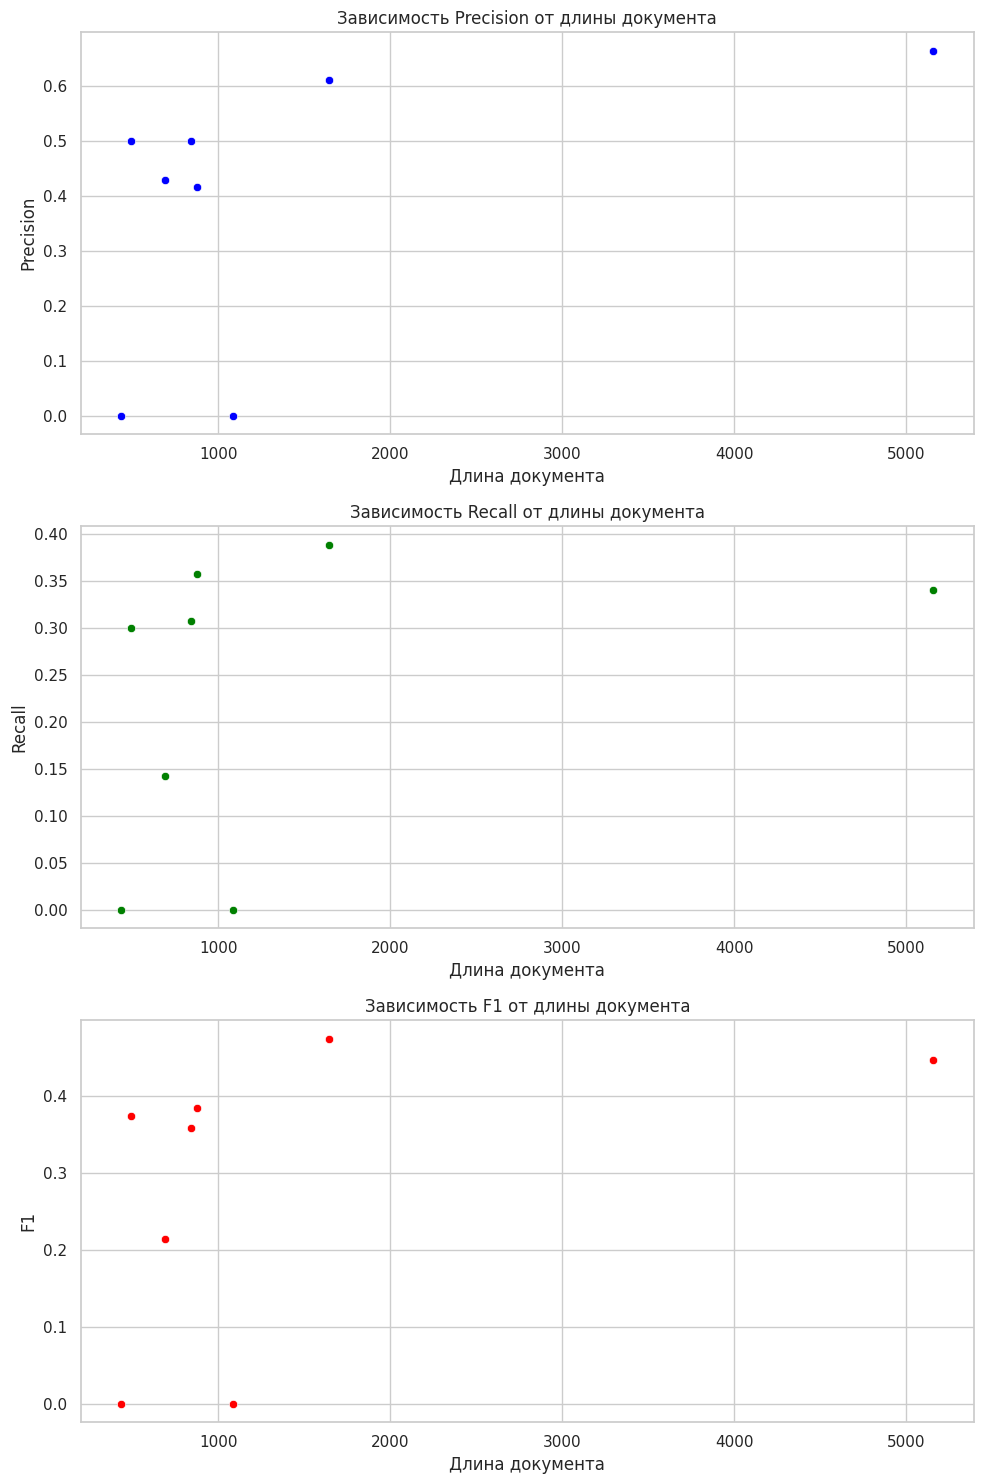

In [176]:
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Зависимость precision от длины документа
sns.scatterplot(data=agg_results, x='document_length', y='precision', ax=axes[0], color='blue')
axes[0].set_title('Зависимость Precision от длины документа')
axes[0].set_xlabel('Длина документа')
axes[0].set_ylabel('Precision')

# Зависимость recall от длины документа
sns.scatterplot(data=agg_results, x='document_length', y='recall', ax=axes[1], color='green')
axes[1].set_title('Зависимость Recall от длины документа')
axes[1].set_xlabel('Длина документа')
axes[1].set_ylabel('Recall')

# Зависимость F1 от длины документа
sns.scatterplot(data=agg_results, x='document_length', y='f1', ax=axes[2], color='red')
axes[2].set_title('Зависимость F1 от длины документа')
axes[2].set_xlabel('Длина документа')
axes[2].set_ylabel('F1')

plt.tight_layout()
plt.show()

Сложно сделать выводы относительно корреляции длины документа и скора из-за нехватки данных и выбросов.

# Анализ ошибок и выводы по исследованию

Задание 8
Проведите анализ ошибок. Когда модель чаще отвечает правильно, а когда ошибается? Предложите варианты, как повысить метрики.



Посмотрим почему метрики у двух документов 0.

In [166]:
chain = model | StrOutputParser()

# Обработка моделью документа ru-1002
ans = chain.invoke(create_llm_input_message(df.iloc[3]))

In [168]:
print(ans)

{
  "События": ["отставка министра иностранных дел Бориса Джонсона", "отставка министра по делам «Брекзит» Дэвида Дэвиса"],
  "Локации": [],
  "Личности": ["Премьер-министр Великобритании Тереза Мей", "министр иностранных дел Борис Джонсон", "министр по делам «Брекзит» Дэвид Дэвис"],
  "Организации": [],
  "Продукты": []
}


In [177]:
true_df_with_docs[true_df_with_docs.document_id == 'ru-1002']

,document_id,entity,gold_answer,document_text
72,ru-1002,PER,Борис Джонсон,09.07.2018 18:09 : Премьер-министр Великобрит...
73,ru-1002,EVT,Брекзит,09.07.2018 18:09 : Премьер-министр Великобрит...
74,ru-1002,LOC,Великобритания,09.07.2018 18:09 : Премьер-министр Великобрит...
75,ru-1002,PER,Дэвид Дэвис,09.07.2018 18:09 : Премьер-министр Великобрит...
76,ru-1002,ORG,ЕС,09.07.2018 18:09 : Премьер-министр Великобрит...
77,ru-1002,ORG,Евросоюз,09.07.2018 18:09 : Премьер-министр Великобрит...
78,ru-1002,PER,Тереза Мей,09.07.2018 18:09 : Премьер-министр Великобрит...


В данном случае все понятно, модель предсказывает слишком развернутый ответ, данная проблема решается граммотным промпт инжинирингом.

In [169]:
# Обработка моделью документа ru-1004
ans2 = chain.invoke(create_llm_input_message(df.iloc[5]))

In [170]:
print(ans2)

{
  "События": ["отставка главы МИД Великобритании", "отставка министра по вопросам Brexit Дэвида Дэвиса"],
  "Локации": [],
  "Личности": ["Борис Джонсон", "Дэвид Дэвис", "Тереза Мэй"],
  "Организации": [],
  "Продукты": []
}


In [178]:
true_df_with_docs[true_df_with_docs.document_id == 'ru-1004']

,document_id,entity,gold_answer,document_text
89,ru-1004,EVT,,Борис Джонсон ушел в отставку с поста главы М...
90,ru-1004,PER,,Борис Джонсон ушел в отставку с поста главы М...
91,ru-1004,LOC,,Борис Джонсон ушел в отставку с поста главы М...
92,ru-1004,PER,,Борис Джонсон ушел в отставку с поста главы М...
93,ru-1004,PER,,Борис Джонсон ушел в отставку с поста главы М...
94,ru-1004,PER,,Борис Джонсон ушел в отставку с поста главы М...
95,ru-1004,PER,,Борис Джонсон ушел в отставку с поста главы М...
96,ru-1004,ORG,,Борис Джонсон ушел в отставку с поста главы М...
97,ru-1004,ORG,,Борис Джонсон ушел в отставку с поста главы М...
98,ru-1004,LOC,,Борис Джонсон ушел в отставку с поста главы М...


В этом документе проблема с парсингом, которую я не заметил на этапе парсинга документов, проблема решается лучшей реализацией парсинга документов.

После просмотра исходного файла, я обнаружил ошибку разметки, где на 2 месте вместо сущности стоит пропуски, из-за этого парсинг работает некорректно.

Посмотрим также почему скор 0 на категории "Продукты".

In [186]:
true_df_with_docs[true_df_with_docs.entity == 'PRO']

,document_id,entity,gold_answer,document_text
45,ru-1000,PRO,The Guardian,Подробности.ua: Третий за сутки: Борис Джонсо...
54,ru-1000,PRO,Подробности.ua,Подробности.ua: Третий за сутки: Борис Джонсо...
108,ru-1006,PRO,Facebook,Захарова лирически прокомментировала отставку...
121,ru-1011,PRO,The Guardian,За Борисом Джонсоном последует сама Мэй - бри...


In [189]:
pred_df[pred_df.entity == 'PRO']

,document_id,entity,prediction,document_text,document_length
16,ru-10,PRO,британский брексит,Тереза Мэй рассчитывает усидеть в седле до за...,5157


Такой скор получается, потому что в разметке всего 4 строки с сущностью из категории продуктов, а модель идентифицировала всего одну и неправильно. Возможно, проблема решается более грамотным промт инжинирингом или использованием более сильной модели.

Выводы:
В этом исследовании я выявил основные паттерны поведеняи модели GigaChat (light версия) в задачи выделения и классификации сущностей. Итоги следующие:
- Модель хорошо справляется с категорией "Личности", однако с остальными у нее наблюдаются проблемы, а из категории "Продукты" нет вообще правильных предсказаний.
- Модель старается избегать ложных срабатываний, из-за чего она пропускает некоторые сущности, которые должны быть предсказаны.
- Не удалось выявить явную зависимость между длинной документа и метрикой.
- Модель предсказала излишне полный ответ для одного из документов.
- Модель сталкнулась с проблемой блэклиста при обработке одного из документов.

Что можно улучшить:
- Использовать больше данных для исследования, чтобы установить взаимосвязь между длинной документа и скором.
- Модифицировать парсинг, чтобы избавиться от ошибок
- Использовать более сильные версии моделей GigaChat
- Улучшить промты

В данном исследовании я впервые поработал с моделью GigaChat и ее API, а так же библиотекой GigaChain, хотя она завязана на Langchain, поэтому проблем не возникло. Так же это мой первый опыт в использовании LLM в качестве решения задачи NER.